In [ ]:
!nvidia-smi

In [ ]:
import torch
torch.cuda.is_available()

## Download CRE Stereo code & requirements

In [1]:
!git clone https://github.com/megvii-research/CREStereo.git

Cloning into 'CREStereo'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 80 (delta 26), reused 53 (delta 9), pack-reused 0
Receiving objects: 100% (80/80), 3.71 MiB | 6.12 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [2]:
!pip install -r CREStereo/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.6/936.6 MB 899.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.4/699.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 2.9 MB/s eta 0:00:00
  Created wheel for mprop: filename=mprop-0.16.0-py3-none-any.whl size=3211 sha256=842a2ac639555c766f2ff4533692e092210344ca0461a04009a85884eafc7efd
  Stored in directory: /root/.cache/pip/wheels/0a/0d/bc/3cd7ea80f4974b68475

May have to resolve typo in `/content/CREStereo/nets/corr.py:39`:
```
TypeError: pad() got an unexpected keyword argument 'pad_witdth'
```

Change `/content/CREStereo/test.py:99` to
```
disp_vis = disp
```
Also remove color-mapping in `/content/CREStereo/test.py:101`

## Generate left disparity map

In [ ]:
!python3 CREStereo/test.py --model CREStereo/crestereo_eth3d.mge --left CREStereo/im0.png --right CREStereo/im1.png --size 695x555 --output left_disparity.png
# !mv left_disparity.png CREStereo/img/test/roses_left_disparity.png


## Generate right disparity map

In [ ]:
# !pip install opencv-python

import cv2
from google.colab.patches import cv2_imshow

'''
Rotate left and right disparity maps
'''
left_img = cv2.imread("CREStereo/img0.png")
rotated_left_img = left_img[:, ::-1]
# cv2_imshow(rotated_left_img)
cv2.imwrite("img0_rotated.png", rotated_left_img)

right_img = cv2.imread("CREStereo/img1.png")
rotated_right_img = right_img[:, ::-1]
# cv2_imshow(rotated_right_img)
cv2.imwrite("img1_rotated.png", rotated_right_img)

!mv img1_rotated.png CREStereo/img1_rotated.png
!mv img0_rotated.png CREStereo/img0_rotated.png

'''
Generate rotated version of right disparity map
'''
!python3 CREStereo/test.py --model CREStereo/crestereo_eth3d.mge --left CREStereo/img1_rotated.png --right CREStereo/img0_rotated.png --size 695x555 --output right_disparity_rotated.png


Loading model: /content/CREStereo/crestereo_eth3d.mge
Images resized: 695x555
Model Forwarding...
Done! Result path: /content/right_disparity_rotated.png


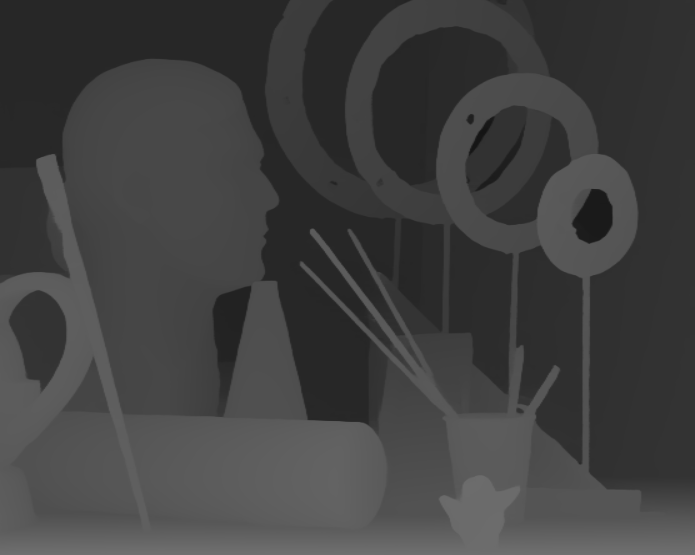

mv: 'right_disparity.png' and 'right_disparity.png' are the same file


In [ ]:
'''
Correct orientation of right disparity map
'''
right_disp_rotated = cv2.imread("right_disparity_rotated.png")
right_disp = right_disp_rotated[:, ::-1]
cv2_imshow(right_disp)
cv2.imwrite("right_disparity.png", right_disp)

!mv right_disparity.png right_disparity.png

## Convert disparity maps to grayscale

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def convertRgbToGrayscale(color_image, side):
    # This solution is based on
    # https://stackoverflow.com/questions/51824718/opencv-jetmap-or-colormap-to-grayscale-reverse-applycolormap
    # create an inverse from the colormap to gray values
    gray_values = np.arange(256, dtype=np.uint8)
    color_values = map(tuple, cv2.applyColorMap(gray_values, cv2.COLORMAP_INFERNO).reshape(256, 3))
    color_to_gray_map = dict(zip(color_values, gray_values))

    # apply the inverse map to the false color image to reconstruct the grayscale image
    gray_image = np.apply_along_axis(lambda bgr: color_to_gray_map[tuple(bgr)], 2, color_image)

    # save reconstructed grayscale image
    cv2.imwrite(f'grayscale_disp_map_{side}.png', gray_image)
    return gray_image

disp = cv2.imread("CREStereo/img/test/roses_left_disparity.png", cv2.IMREAD_UNCHANGED)
left_disp_gray = convertRgbToGrayscale(disp, "left")

cv2_imshow(left_disp_gray)

disp = cv2.imread("CREStereo/img/test/roses_right_disparity.png", cv2.IMREAD_UNCHANGED)
right_disp_gray = convertRgbToGrayscale(disp, "right")

cv2_imshow(right_disp_gray)

# Batch

In [ ]:
!unzip test.zip

In [4]:
import cv2
from google.colab import files

imgs = [
    # "art",
    "flowerbed",
    "lilies",
    "statue",
    "sunflowers",
    "tree",
    "trees",
    "woods",
    "roses",
    "rock",
    "peaches",
    "mug",
    "grapes"
]

for img in imgs:
  left_img = cv2.imread(f"test/{img}/{img}_L.png")
  right_img = cv2.imread(f"test/{img}/{img}_R.png")
  x = left_img.shape[0]
  y = left_img.shape[1]
  !python3 CREStereo/test.py --model CREStereo/crestereo_eth3d.mge --left test/{img}/{img}_L.png --right test/{img}/{img}_R.png --size {x}x{y} --output test/{img}/left_disparity.png

  rotated_left_img = left_img[:, ::-1]
  cv2.imwrite(f"test/{img}/{img}_L_rotated.png", rotated_left_img)
  rotated_right_img = right_img[:, ::-1]
  cv2.imwrite(f"test/{img}/{img}_R_rotated.png", rotated_right_img)

  !python3 CREStereo/test.py --model CREStereo/crestereo_eth3d.mge --left test/{img}/{img}_R_rotated.png --right test/{img}/{img}_L_rotated.png --size {x}x{y} --output test/{img}/right_disparity_rotated.png

  right_disp_rotated = cv2.imread(f"test/{img}/right_disparity_rotated.png")
  right_disp = right_disp_rotated[:, ::-1]
  cv2.imwrite(f"test/{img}/right_disparity.png", right_disp)

  !rm -f /content/test/{img}/{img}_R_rotated.png
  !rm -f /content/test/{img}/right_disparity_rotated.png
  !rm -f /content/test/{img}/{img}_L_rotated.png

!zip -r test.zip test
files.download(f"test.zip")

Loading model: /content/CREStereo/crestereo_eth3d.mge
Images resized: 450x800
Model Forwarding...
Done! Result path: /content/test/flowerbed/left_disparity.png
Loading model: /content/CREStereo/crestereo_eth3d.mge
Images resized: 450x800
Model Forwarding...
Done! Result path: /content/test/flowerbed/right_disparity_rotated.png
Loading model: /content/CREStereo/crestereo_eth3d.mge
Images resized: 460x690
Model Forwarding...
Done! Result path: /content/test/lilies/left_disparity.png
Loading model: /content/CREStereo/crestereo_eth3d.mge
Images resized: 460x690
Model Forwarding...
Done! Result path: /content/test/lilies/right_disparity_rotated.png
Loading model: /content/CREStereo/crestereo_eth3d.mge
Images resized: 450x800
Model Forwarding...
Done! Result path: /content/test/statue/left_disparity.png
Loading model: /content/CREStereo/crestereo_eth3d.mge
Images resized: 450x800
Model Forwarding...
Done! Result path: /content/test/statue/right_disparity_rotated.png
Loading model: /content/C

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Middlebury's test images
* Middlebury so images are rectified and NOT likely to be the cause of any issues
* quarter-sized so no scaling required - and generation should be fast
* test images used in evaluating generators for the stereo eval3 dataset so they're good, relevant choices

In [ ]:
import cv2
from google.colab import files

# !unzip test.zip

imgs = [
  # "Australia",
  # "AustraliaP", # TODO
  # "Bicycle2", # TODO
  "Classroom2",
  # "Classroom2E", # TODO
  "Computer",
  # "Crusade", # TODO
  # "CrusadeP", # TODO
  # "Djembe", # TODO
  # "DjembeL", # TODO
  "Hoops",
  # "Livingroom",
  # "Newkuba", # TODO
  "Plants",
  "Staircase"
]

for img in imgs:
  left_img = cv2.imread(f"test/{img}/im0.png")
  right_img = cv2.imread(f"test/{img}/im1.png")
  x = left_img.shape[0]
  y = left_img.shape[1]
  !python3 CREStereo/test.py --model CREStereo/crestereo_eth3d.mge --left test/{img}/im0.png --right test/{img}/im1.png --size {x}x{y} --output {img}/left_disparity.png

  rotated_left_img = left_img[:, ::-1]
  cv2.imwrite(f"test/{img}/im0_rotated.png", rotated_left_img)
  rotated_right_img = right_img[:, ::-1]
  cv2.imwrite(f"test/{img}/im1_rotated.png", rotated_right_img)

  !python3 CREStereo/test.py --model CREStereo/crestereo_eth3d.mge --left test/{img}/im1_rotated.png --right test/{img}/im0_rotated.png --size {x}x{y} --output {img}/right_disparity_rotated.png

  right_disp_rotated = cv2.imread(f"{img}/right_disparity_rotated.png")
  right_disp = right_disp_rotated[:, ::-1]
  cv2.imwrite(f"{img}/right_disparity.png", right_disp)

  !rm -f /content/test/{img}/im1_rotated.png
  !rm -f /content/test/{img}/im0_rotated.png

# !zip -r test.zip test
# files.download(f"test.zip")

Loading model: /content/CREStereo/crestereo_eth3d.mge
